# Anomaly Detection using Autoencoders

This notebook demonstrates how to use an Autoencoder neural network to detect anomalies in server log data. 

**Steps covered:**
1.  **Data Loading**: Parsing raw log files into a structured DataFrame.
2.  **Feature Engineering**: Transforming and normalizing data for the model.
3.  **Model Building**: Creating an Autoencoder using TensorFlow/Keras.
4.  **Training**: Training the model to reconstruct normal data.
5.  **Anomaly Detection**: Identifying anomalies based on high reconstruction error.

## 1. Import Libraries
Importing necessary libraries for data manipulation, visualization, and deep learning.

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## 2. Data Loading and Parsing
Reading the raw log file and parsing it using Regular Expressions (Regex) to extract meaningful fields like Timestamp, IP, Status, Size, etc.

In [2]:
# Define the regex pattern for log parsing
# Updated to use \S+ for numeric fields to be more robust
log_pattern = re.compile(r'<(\d+)>(\w{3}\s+\d+\s+\d{2}:\d{2}:\d{2})\s+(\S+)\s+(\S+):\s+(\S+)\s+(\S+)\s+(\d+)\s+(\S+)\s+-\s+-\s+\[(.*?)\]\s+"(.*?)"\s+(\S+)\s+(\S+)\s+(\S+)\s+"(.*?)"\s+"(.*?)"')

data = []
file_path = 'synthetic_logs_10k.csv'

with open(file_path, 'r') as f:
    for line in f:
        match = log_pattern.match(line.strip())
        if match:
            data.append(match.groups())

# Create DataFrame
columns = [
    'Priority', 'Syslog_Timestamp', 'Server', 'Process', 'Client_IP', 
    'Second_IP', 'Port_ID', 'Host', 'Log_Timestamp', 'Request', 
    'Status', 'Size', 'Duration', 'Referer', 'User_Agent'
]
df = pd.DataFrame(data, columns=columns)

# Convert numerical columns
# Force errors='coerce' to turn non-numeric into NaN, then fill with 0
df['Status'] = pd.to_numeric(df['Status'], errors='coerce').fillna(0)
df['Size'] = pd.to_numeric(df['Size'].replace('-', '0'), errors='coerce').fillna(0)
df['Duration'] = pd.to_numeric(df['Duration'].replace('-', '0'), errors='coerce').fillna(0)

# Display first few rows
df.head()

,Priority,Syslog_Timestamp,Server,Process,Client_IP,Second_IP,Port_ID,Host,Log_Timestamp,Request,Status,Size,Duration,Referer,User_Agent
0,150,Jan 28 08:10:01,servernameabc,httpd[12345],10.0.240.52,0.1.0.1,35786,abc.example.net,28/Jan/2026:08:10:01 +0530,GET /leave/appResources/images/lerf_default.pn...,503,0,4468,https://abc.example.com/index.html,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
1,150,Jan 28 08:10:01,servernameabc,httpd[12345],10.91.94.182,0.1.0.1,81525,abc.example.net,28/Jan/2026:08:10:01 +0530,GET /leave/appResources/css/Custom_font-awesom...,200,7895,10,https://abc.example.com/index.html,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
2,150,Jan 28 08:10:02,servernameabc,httpd[12345],10.151.91.182,0.1.0.1,70055,abc.example.net,28/Jan/2026:08:10:02 +0530,POST /leaverest/rest/lwpBatch HTTP/1.1,200,2389,42,https://abc.example.com/index.html,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...
3,150,Jan 28 08:10:02,servernameabc,httpd[12345],10.236.14.117,0.1.0.1,22309,abc.example.net,28/Jan/2026:08:10:02 +0530,GET /favicon.ico HTTP/1.1,200,3822,33,https://abc.example.com/index.html,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
4,150,Jan 28 08:10:03,servernameabc,httpd[12345],10.199.43.68,0.1.0.1,54459,abc.example.net,28/Jan/2026:08:10:03 +0530,GET /leave/appResources/images/lerf_default.pn...,204,0,3405,https://abc.example.com/index.html,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...


## 3. Feature Engineering
Preparing the data for the Autoencoder:
*   Extracting the HTTP Method.
*   One-Hot Encoding categorical variables.
*   Applying Log Transformation to skewed numerical features (`Size`, `Duration`).
*   Normalizing all features to the [0, 1] range using `MinMaxScaler`.

In [3]:
# Feature Engineering

# Extract Method from Request
df['Method'] = df['Request'].apply(lambda x: x.split()[0] if len(x.split()) > 0 else 'UNKNOWN')

# Select features for the model
features = ['Status', 'Size', 'Duration', 'Method']
data_model = df[features].copy()

# One-Hot Encode categorical features (Method)
data_model = pd.get_dummies(data_model, columns=['Method'])

# Log transform Size and Duration to handle skewness
# Log1p is log(1+x) to handle 0 values
data_model['Size'] = np.log1p(data_model['Size'])
data_model['Duration'] = np.log1p(data_model['Duration'])

# Convert all columns to float
data_model = data_model.astype('float32')

# Normalize numerical features
scaler = MinMaxScaler()
numerical_cols = ['Status', 'Size', 'Duration']
data_model[numerical_cols] = scaler.fit_transform(data_model[numerical_cols])

print("Features shape:", data_model.shape)
data_model.head()

Features shape: (10000, 5)


,Status,Size,Duration,Method_GET,Method_POST
0,1.000000,0.000000,0.983277,1.0,0.0
1,0.000000,0.906157,0.090123,1.0,0.0
2,0.000000,0.785486,0.292826,0.0,1.0
3,0.000000,0.832918,0.257909,1.0,0.0
4,0.013201,0.000000,0.942890,1.0,0.0


## 4. Model Architecture and Training
*   **Architecture**: An encoder compresses the input into a lower-dimensional latent space, and a decoder reconstructs the input from this representation.
*   **Training**: The model is trained to minimize the Mean Squared Error (MSE) between the input and the output. It learns the pattern of "normal" data.

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 537 (2.10 KB)

 Trainable params: 537 (2.10 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0904 - val_loss: 0.0299
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0156 - val_loss: 0.0075
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0052 - val_loss: 0.0036
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028 - val_loss: 0.0021
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

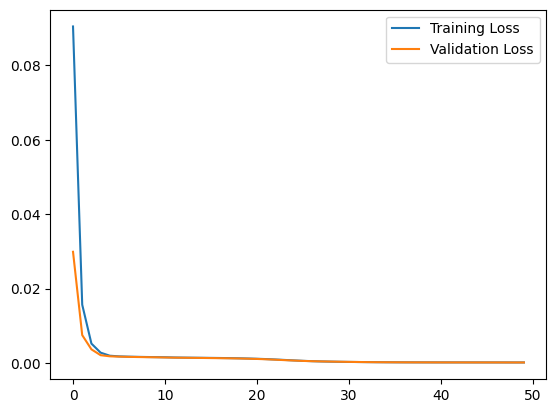

In [4]:
# Split data into train and test
X_train, X_test = train_test_split(data_model, test_size=0.2, random_state=42)

# Input dimension
input_dim = data_model.shape[1]

# Build the Autoencoder
input_layer = Input(shape=(input_dim,))
encoder = Dense(16, activation="relu")(input_layer)
encoder = Dense(8, activation="relu")(encoder)
encoder = Dense(4, activation="relu")(encoder)

decoder = Dense(8, activation="relu")(encoder)
decoder = Dense(16, activation="relu")(decoder)
decoder = Dense(input_dim, activation="sigmoid")(decoder) # Sigmoid because data is scaled to [0, 1]

autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

# Train the model
history = autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_data=(X_test, X_test),
    verbose=1
)

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

## 5. Anomaly Detection
*   Calculate the **Reconstruction Error** (MSE) for each data point.
*   Define a **Threshold** (e.g., Mean + 2 Standard Deviations).
*   Data points with error > threshold are flagged as **Anomalies**.

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


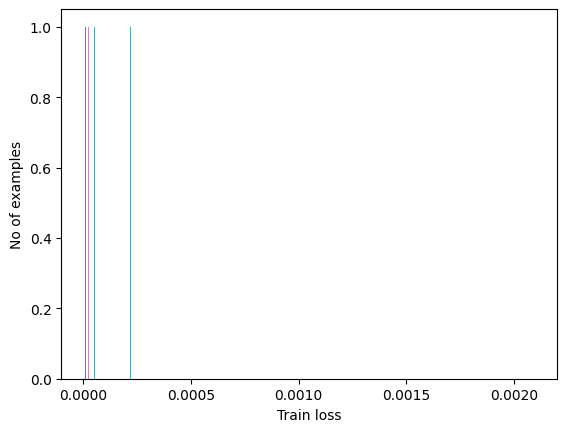

Threshold: 0.0003872134
Number of anomalies found: 299
Anomalies Preview:
    Priority Syslog_Timestamp         Server       Process      Client_IP  \
78       150  Jan 28 08:11:05  servernameabc  httpd[12345]     10.1.93.93   
107      150  Jan 28 08:11:29  servernameabc  httpd[12345]   10.128.235.6   
123      150  Jan 28 08:11:44  servernameabc  httpd[12345]  10.182.111.88   
136      150  Jan 28 08:11:54  servernameabc  httpd[12345]  10.15.105.100   
144      150  Jan 28 08:11:58  servernameabc  httpd[12345]   10.254.0.109   

    Second_IP Port_ID             Host               Log_Timestamp  \
78    0.1.0.1   12392  abc.example.net  28/Jan/2026:08:11:05 +0530   
107   0.1.0.1   99316  abc.example.net  28/Jan/2026:08:11:29 +0530   
123   0.1.0.1   77602  abc.example.net  28/Jan/2026:08:11:44 +0530   
136   0.1.0.1   81830  abc.example.net  28/Jan/2026:08:11:54 +0530   
144   0.1.0.1   63206  abc.example.net  28/Jan/2026:08:11:58 +0530   

                                          

In [5]:
# Calculate reconstruction error on the whole dataset
reconstructions = autoencoder.predict(data_model)
train_loss = tf.keras.losses.mse(reconstructions, data_model)

# Plot the distribution of the reconstruction loss
plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

# Define a threshold for anomaly detection
# Here we use mean + 2 * std deviation
threshold = np.mean(train_loss) + 2 * np.std(train_loss)
print("Threshold:", threshold)

# Identify anomalies
anomalies = train_loss > threshold
print(f"Number of anomalies found: {np.sum(anomalies)}")

# Add anomaly label to the original dataframe
df['Anomaly'] = anomalies
df['Reconstruction_Error'] = train_loss

# Inspect some anomalies
print("Anomalies Preview:")
print(df[df['Anomaly'] == True].head())

## 6. Inference on New Data with Explainability
This section allows you to upload a new log file (CSV), detect anomalies using the trained model, and generate explanations using SHAP and OpenAI.

In [ ]:
import shap
import openai
from keys import OPENAI_API_KEY

# --- Configuration ---

# --- Helper Functions ---

def preprocess_new_logs(file_path, train_columns, scaler):
    """
    Parses and preprocesses a new log file to match the training data format.
    """
    data = []
    # Reuse the global log_pattern from the notebook
    with open(file_path, 'r') as f:
        for line in f:
            match = log_pattern.match(line.strip())
            if match:
                data.append(match.groups())

    columns = [
        'Priority', 'Syslog_Timestamp', 'Server', 'Process', 'Client_IP', 
        'Second_IP', 'Port_ID', 'Host', 'Log_Timestamp', 'Request', 
        'Status', 'Size', 'Duration', 'Referer', 'User_Agent'
    ]
    df_new = pd.DataFrame(data, columns=columns)
    
    # Numeric conversion
    df_new['Status'] = pd.to_numeric(df_new['Status'], errors='coerce').fillna(0)
    df_new['Size'] = pd.to_numeric(df_new['Size'].replace('-', '0'), errors='coerce').fillna(0)
    df_new['Duration'] = pd.to_numeric(df_new['Duration'].replace('-', '0'), errors='coerce').fillna(0)

    # Feature Engineering
    df_new['Method'] = df_new['Request'].apply(lambda x: x.split()[0] if len(x.split()) > 0 else 'UNKNOWN')
    
    # Select and encode
    data_model_new = df_new[['Status', 'Size', 'Duration', 'Method']].copy()
    data_model_new = pd.get_dummies(data_model_new, columns=['Method'])
    
    # Log transform
    data_model_new['Size'] = np.log1p(data_model_new['Size'])
    data_model_new['Duration'] = np.log1p(data_model_new['Duration'])
    
    # Align columns with training data
    for col in train_columns:
        if col not in data_model_new.columns:
            data_model_new[col] = 0
    data_model_new = data_model_new[train_columns]
    
    # Convert to float32
    data_model_new = data_model_new.astype('float32')

    # Normalize
    numerical_cols = ['Status', 'Size', 'Duration']
    data_model_new[numerical_cols] = scaler.transform(data_model_new[numerical_cols])
    
    return df_new, data_model_new

def get_reconstruction_error_function(model):
    def predict_error(X):
        # Handle DataFrame or Numpy
        if isinstance(X, pd.DataFrame):
            X = X.values
        rec = model.predict(X)
        # Mean Squared Error per sample
        return np.mean(np.square(X - rec), axis=1)
    return predict_error

def generate_explanation(log_entry, shap_values, feature_names):
    if not OPENAI_API_KEY or "YOUR_API_KEY" in OPENAI_API_KEY:
        return "OpenAI API Key not provided. Skipping detailed explanation."
        
    client = openai.OpenAI(api_key=OPENAI_API_KEY)
    
    # Summarize top features
    # shap_values is an array matching feature_names
    feat_importance = sorted(zip(feature_names, shap_values), key=lambda x: -abs(x[1]))
    top_features = feat_importance[:5]
    
    shap_text = ", ".join([f"{f}: {v:.4f}" for f, v in top_features])
    
    prompt = f"""
    Analyze this server log anomaly.
    Log Details: {log_entry}
    Key contributors to anomaly score (SHAP values): {shap_text}
    
    Provide a simple, easy-to-understand explanation of why this is anomalous. Avoid technical jargon where possible, as this is for a general user.
    """
    
    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[{"role": "user", "content": prompt}]
        )
        return response.choices[0].message.content
    except Exception as e:
        return f"Error generating explanation: {e}"

c:\Users\Rhea\Desktop\Tasks\Tool - CybSec\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Processing synthetic_logs_10k.csv...
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Found 299 anomalies.
Initializing SHAP explainer...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Anomaly at Index 4391 | Error: 0.0021
Request: POST /RightsWeb/myrights/rest/getNewCardBranch HTTP/1.1
Status: 200 | Size: 208 | IP: 10.121.54.226


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


100%|██████████| 1/1 [00:00<00:00,  3.64it/s]
C:\Users\Rhea\AppData\Local\Temp\ipykernel_28252\3333749819.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Contribution', y='Feature', data=df_shap, palette='viridis')


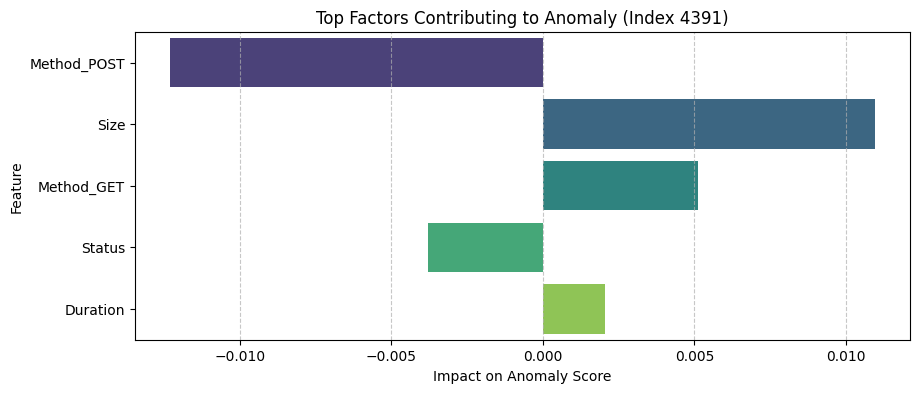


Analysis:
 This server log anomaly is characterized by a few key factors. The log shows a POST request being made to a specific endpoint on the server, with a status code of 200 (indicating a successful request) and a relatively small response size of 208 bytes. The duration of the request was 19 milliseconds, and the user agent string suggests the request was made from a mobile device running Android.

The anomaly score has been computed using SHAP values, with the Method_POST, Size, Status, and Duration features contributing to the score. In this case, a small negative SHAP value for Method_POST suggests that the fact that the request was a POST method may be contributing to the anomaly. Additionally, the positive SHAP value for Size and the negative values for Status and Duration also suggest potential anomalies.

A security analyst should investigate further to determine the reason for the anomaly. They should check if the request made to the server is expected and legitimate, as 

  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


100%|██████████| 1/1 [00:00<00:00,  3.48it/s]
C:\Users\Rhea\AppData\Local\Temp\ipykernel_28252\3333749819.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Contribution', y='Feature', data=df_shap, palette='viridis')


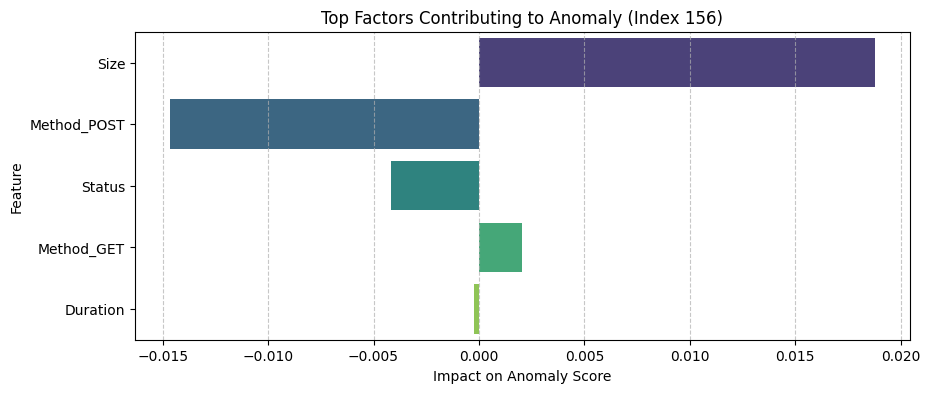


Analysis:
 This log entry is considered anomalous for several reasons:

1. Unusual Second_IP: The presence of a Second_IP value of '0.1.0.1' is suspicious as it is not a typical IP address format and could indicate potential tampering or spoofing.

2. Large Size and Short Duration: The combination of a large Size value (219) and a short Duration time (36) for a POST request can indicate a potential data exfiltration attempt. A large amount of data being sent in a short amount of time is not typical behavior for normal web usage.

3. Uncommon User-Agent: The User-Agnet in this log entry appears to be using an unusual version of Chrome (144.0.0.0) on Android 10. This could be a sign of a spoofed or malicious User-Agent header.

4. Unusual Request URI: The Request URI 'POST /RightsWeb/myrights/rest/getNewCardBranch HTTP/1.1' does not match a typical pattern for legitimate web requests, which could indicate an attempt to access restricted or sensitive information.

Overall, a security ana

  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


100%|██████████| 1/1 [00:00<00:00,  3.67it/s]
C:\Users\Rhea\AppData\Local\Temp\ipykernel_28252\3333749819.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Contribution', y='Feature', data=df_shap, palette='viridis')


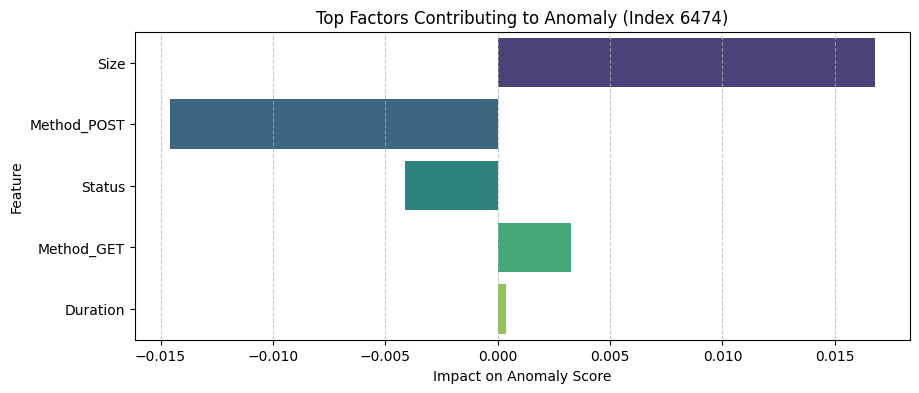


Analysis:
 This log entry is considered anomalous primarily due to the following factors:
1. The Second_IP field has a suspicious value of '0.1.0.1', which is not a valid IP address format. This could indicate a potential spoofing or tampering attempt by the client.
2. The Referer field shows a URL from 'https://abc.example.com', which is different from the Server and Host fields. This could suggest a cross-site request forgery (CSRF) attack or unauthorized access.
3. The User_Agent field indicates the request was made from an iPhone device, which might be unusual for a server log entry related to httpd processing.

As a security analyst, it would be crucial to investigate the following aspects:
1. Verify the legitimacy of the Client_IP and Second_IP addresses to rule out any IP address spoofing or malicious intent.
2. Investigate the Referer URL to determine if it is a trusted source and validate the authenticity of the request.
3. Review the User_Agent field and cross-reference it w

In [14]:
# --- Load and Analyze ---
NEW_LOG_FILE = 'synthetic_logs_10k.csv' # CHANGE THIS to your new file path

print(f"Processing {NEW_LOG_FILE}...")
try:
    # Ensure X_train is available for column alignment and SHAP background
    if 'X_train' not in locals():
        print("Variable 'X_train' is missing. Please run the training cells above.")
    else:
        df_test, X_test_processed = preprocess_new_logs(NEW_LOG_FILE, X_train.columns, scaler)
        
        # Calculate Error
        reconstructions = autoencoder.predict(X_test_processed)
        mse = tf.keras.losses.mse(reconstructions, X_test_processed)
        
        # Detect Anomalies
        anomalies_mask = mse > threshold
        print(f"Found {np.sum(anomalies_mask)} anomalies.")
        
        if np.sum(anomalies_mask) > 0:
            # Initialize SHAP
            print("Initializing SHAP explainer...")
            # Use a summary of background data to speed up
            background = shap.sample(X_train, 50) 
            predict_fn = get_reconstruction_error_function(autoencoder)
            explainer = shap.KernelExplainer(predict_fn, background)
            
            # Explain the top 3 anomalies by error
            anomaly_indices = np.where(anomalies_mask)[0]
            # Sort by error descending
            sorted_indices = anomaly_indices[np.argsort(mse.numpy()[anomaly_indices])[::-1]]
            top_indices = sorted_indices[:3]
            
            for idx in top_indices:
                print(f"\n{'='*50}")
                print(f"Anomaly at Index {idx} | Error: {mse[idx]:.4f}")
                log_row = df_test.iloc[idx]
                # Display relevant fields
                print(f"Request: {log_row['Request']}") 
                print(f"Status: {log_row['Status']} | Size: {log_row['Size']} | IP: {log_row['Client_IP']}")
                
                # Calculate SHAP values for this instance
                instance = X_test_processed.iloc[[idx]]
                shap_vals = explainer.shap_values(instance)
                
                # Simpler Visualization: Bar Chart of Top Features
                shap_values_flat = shap_vals[0]
                feature_names = X_test_processed.columns
                
                # Create a DataFrame for plotting
                df_shap = pd.DataFrame({
                    'Feature': feature_names,
                    'Contribution': shap_values_flat
                })
                # Sort by absolute contribution
                df_shap['AbsContribution'] = df_shap['Contribution'].abs()
                df_shap = df_shap.sort_values('AbsContribution', ascending=False).head(5)
                
                plt.figure(figsize=(10, 4))
                sns.barplot(x='Contribution', y='Feature', data=df_shap, palette='viridis')
                plt.title(f'Top Factors Contributing to Anomaly (Index {idx})')
                plt.xlabel('Impact on Anomaly Score')
                plt.grid(axis='x', linestyle='--', alpha=0.7)
                plt.show()
                
                # Explain
                explanation = generate_explanation(log_row.to_dict(), shap_vals[0], X_test_processed.columns)
                print("\nAnalysis:\n", explanation)
                
        else:
            print("No anomalies detected in the new file.")

except Exception as e:
    print(f"An error occurred: {e}")
    import traceback
    traceback.print_exc()